In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from importlib.metadata import version

print("Numpy version: " + str(np.__version__))
print("Pandas version: " + str(pd.__version__))
print("Sklearn version: " + str(version("scikit-learn")))
print("XGBoost version: " + str(xgb.__version__))
print("Matplotlib version: " + str(version("matplotlib")))

Numpy version: 2.3.5
Pandas version: 2.3.3
Sklearn version: 1.7.2
XGBoost version: 3.1.2
Matplotlib version: 3.10.7


In [2]:
# read data
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

df = pd.read_csv(url)

df.shape

(9704, 11)

In [3]:
# first 5 rows
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
# n missing values
df.isna().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [5]:
numeric_cols = ['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight', 'acceleration', 'model_year', 'num_doors', 'fuel_efficiency_mpg']
categorical_cols = ['origin', 'fuel_type', 'drivetrain']

# fill missing values for numeric columns
df[numeric_cols] = df[numeric_cols].fillna(0)

df.isna().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [6]:
# split the data, first split into train (60%) and temp (40%)
df_train, df_temp = train_test_split(df, test_size = 0.4, random_state = 1)

# split the temp set into validation (20%) and test (20%)
df_val, df_test = train_test_split(df_temp, test_size = 0.5, random_state = 1)

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)

Train shape: (5822, 11)
Validation shape: (1941, 11)
Test shape: (1941, 11)


In [7]:
# separate target from features
target = 'fuel_efficiency_mpg'
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

X_train = df_train.drop(columns = [target])
X_val = df_val.drop(columns = [target])
X_test = df_test.drop(columns = [target])

# use DictVectorizer to turn dataframes into matrices
dv = DictVectorizer(sparse = True)
X_train_matrix = dv.fit_transform(X_train.to_dict(orient = 'records'))
X_val_matrix = dv.transform(X_val.to_dict(orient = 'records'))
X_test_matrix = dv.transform(X_test.to_dict(orient = 'records'))

print("Train matrix shape:", X_train_matrix.shape)
print("Validation matrix shape:", X_val_matrix.shape)
print("Test matrix shape:", X_test_matrix.shape)

Train matrix shape: (5822, 14)
Validation matrix shape: (1941, 14)
Test matrix shape: (1941, 14)


In [8]:
# train decision tree regressor with max_depth = 1
dt = DecisionTreeRegressor(max_depth = 1, random_state = 1)
dt.fit(X_train_matrix, y_train)

# check which feature is used for the root split
feature_names = dv.get_feature_names_out()
root_feature = feature_names[dt.tree_.feature[0]]

print("Feature used for splitting:", root_feature)

Feature used for splitting: vehicle_weight


In [9]:
# train random forest regressor
rf = RandomForestRegressor(
    n_estimators = 10,
    random_state = 1,
    n_jobs = -1  # optional, speeds up training
)

rf.fit(X_train_matrix, y_train)

# predict on validation set
y_val_pred = rf.predict(X_val_matrix)

# compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print("Validation RMSE:", rmse)

Validation RMSE: 0.4610645464796066


In [10]:
# range of n_estimators
n_estimators_list = range(10, 201, 10)
rmse_list = []

for n in n_estimators_list:
    rf = RandomForestRegressor(n_estimators = n, random_state = 1, n_jobs = -1)
    rf.fit(X_train_matrix, y_train)
    y_val_pred = rf.predict(X_val_matrix)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    rmse_list.append(rmse)
    print(f"n_estimators = {n}, RMSE = {rmse:.3f}")

n_estimators = 10, RMSE = 0.461
n_estimators = 20, RMSE = 0.447
n_estimators = 30, RMSE = 0.441
n_estimators = 40, RMSE = 0.440
n_estimators = 50, RMSE = 0.438
n_estimators = 60, RMSE = 0.436
n_estimators = 70, RMSE = 0.437
n_estimators = 80, RMSE = 0.437
n_estimators = 90, RMSE = 0.436
n_estimators = 100, RMSE = 0.436
n_estimators = 110, RMSE = 0.436
n_estimators = 120, RMSE = 0.436
n_estimators = 130, RMSE = 0.436
n_estimators = 140, RMSE = 0.436
n_estimators = 150, RMSE = 0.436
n_estimators = 160, RMSE = 0.436
n_estimators = 170, RMSE = 0.436
n_estimators = 180, RMSE = 0.436
n_estimators = 190, RMSE = 0.436
n_estimators = 200, RMSE = 0.435


In [11]:
# candidate max_depth values
max_depths = [10, 15, 20, 25]
n_estimators_list = range(10, 201, 10)

mean_rmse_per_depth = {}

for depth in max_depths:
    rmse_list = []
    for n in n_estimators_list:
        rf = RandomForestRegressor(n_estimators = n, max_depth = depth, random_state = 1, n_jobs = -1)
        rf.fit(X_train_matrix, y_train)
        y_val_pred = rf.predict(X_val_matrix)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        rmse_list.append(rmse)
    mean_rmse = np.mean(rmse_list)
    mean_rmse_per_depth[depth] = mean_rmse
    print(f"max_depth = {depth}, mean RMSE = {mean_rmse:.3f}")

max_depth = 10, mean RMSE = 0.436
max_depth = 15, mean RMSE = 0.438
max_depth = 20, mean RMSE = 0.438
max_depth = 25, mean RMSE = 0.438


In [12]:
# train the random forest model
rf = RandomForestRegressor(
    n_estimators = 10,
    max_depth = 20,
    random_state = 1,
    n_jobs = -1
)

rf.fit(X_train_matrix, y_train)

# get feature importances
importances = rf.feature_importances_
feature_names = dv.get_feature_names_out()

# find the most important feature
most_important_idx = np.argmax(importances)
most_important_feature = feature_names[most_important_idx]

print("Most important feature:", most_important_feature)

Most important feature: vehicle_weight


In [13]:
# create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_matrix, label = y_train)
dval = xgb.DMatrix(X_val_matrix, label = y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]

# function to train and evaluate model for a given eta
def train_xgb(eta_value):
    xgb_params = {
        'eta': eta_value, 
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 0
    }
    
    model = xgb.train(
        params = xgb_params,
        dtrain = dtrain,
        num_boost_round = 100,
        evals = watchlist,
        early_stopping_rounds = 10,
        verbose_eval = False
    )
    
    # predict on validation set
    y_val_pred = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    return rmse

# train with eta = 0.3
rmse_03 = train_xgb(0.3)
print("RMSE with eta = 0.3:", rmse_03)

# train with eta = 0.1
rmse_01 = train_xgb(0.1)
print("RMSE with eta = 0.1:", rmse_01)

RMSE with eta = 0.3: 0.42667344498698967
RMSE with eta = 0.1: 0.41651145559432473


RMSE with eta = 0.3: 0.42667344498698967
RMSE with eta=0.1: 0.41651145559432473


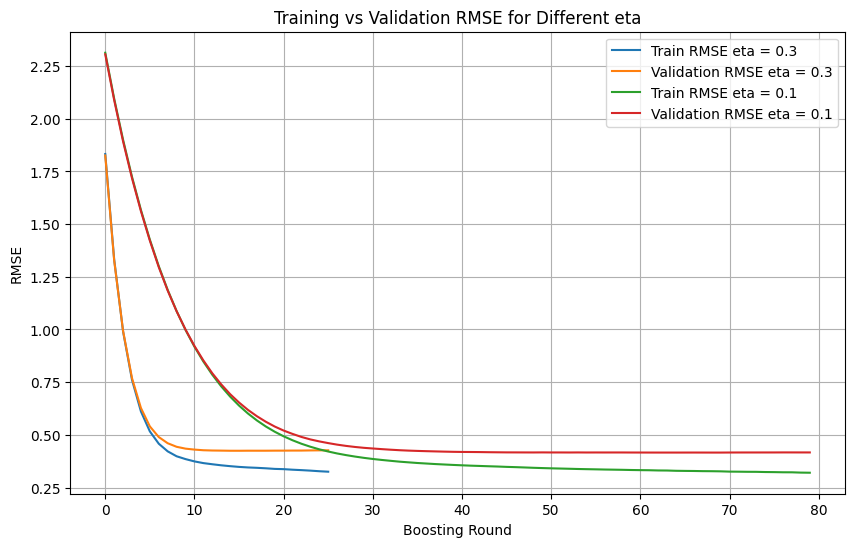

In [14]:
# plot results
# create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_matrix, label = y_train)
dval = xgb.DMatrix(X_val_matrix, label = y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]

# function to train and evaluate model for a given eta and capture evals_result
def train_xgb(eta_value):
    evals_result = {}  # dictionary to store training and validation metrics
    
    xgb_params = {
        'eta': eta_value, 
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 0
    }
    
    model = xgb.train(
        params = xgb_params,
        dtrain = dtrain,
        num_boost_round = 100,
        evals = watchlist,
        evals_result = evals_result,
        early_stopping_rounds = 10,
        verbose_eval = False
    )
    
    # predict on validation set
    y_val_pred = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    return rmse, evals_result

# train with eta = 0.3
rmse_03, evals_03 = train_xgb(0.3)
print("RMSE with eta = 0.3:", rmse_03)

# train with eta = 0.1
rmse_01, evals_01 = train_xgb(0.1)
print("RMSE with eta=0.1:", rmse_01)

# plot training and validation RMSE for both etas
plt.figure(figsize = (10,6))

# eta = 0.3
plt.plot(evals_03['train']['rmse'], label = 'Train RMSE eta = 0.3')
plt.plot(evals_03['val']['rmse'], label = 'Validation RMSE eta = 0.3')

# eta = 0.1
plt.plot(evals_01['train']['rmse'], label = 'Train RMSE eta = 0.1')
plt.plot(evals_01['val']['rmse'], label = 'Validation RMSE eta = 0.1')

plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE for Different eta')
plt.legend()
plt.grid(True)
plt.show()